<img src="https://cybersecurity-excellence-awards.com/wp-content/uploads/2017/06/366812.png">

# Import libraries

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import sys
import numpy as np
import pandas as pd
import re
from pandas import DataFrame, Series
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# A timestamp is used to create a unique name in the event you execute the workflow multiple times or with 
# different datasets.  File names must be unique in Darwin.
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

from amb_sdk.sdk import DarwinSdk

<h1><center>Darwin Supervised Regression Model Building </center></h1>

<img src="https://raw.githubusercontent.com/ykassif/airbnb_darwin/master/images/darwin.jpg">

## Setup Darwin SDK

In [2]:
# Login
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('davebradham@gmail.com', 'dR5xesR3cn')

# Import the data

<img src="https://raw.githubusercontent.com/ykassif/airbnb_darwin/master/images/airbnb.jpg">

In [3]:
# import dataset
temp_data = pd.read_csv('data\listings.csv', header = 0)

# make pandas dataframe with starting columns
data = temp_data[['host_name', 'host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost',
             'host_total_listings_count', 'host_identity_verified', 'neighbourhood', 'property_type', 'room_type',
            'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'extra_people', 'minimum_nights',
            'maximum_nights','availability_30','availability_60','availability_90','availability_365','number_of_reviews',
            'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
            'review_scores_communication','review_scores_location','review_scores_value','instant_bookable',
             'cancellation_policy','calculated_host_listings_count','reviews_per_month','price']]
print(data.shape)

(12126, 35)


## Feature Engineering

**feature engineer the 'host_name' column**

<img src="https://raw.githubusercontent.com/ykassif/airbnb_darwin/master/images/gender.png">

In [4]:
import gender_guesser.detector as gender

d = gender.Detector()
genders = []
comp = []
comp.append("rent")
comp.append("Rent")
comp.append("propert")
comp.append("Propert")
comp.append("vacation")
comp.append("Vacation")
comp.append("LLC")
comp.append("llc")
comp.append("estate")
comp.append("Estate")
comp.append("The")
comp.append('manag')
comp.append("Manag")

compound = []

compound.append('and')
compound.append('And')
compound.append('+')
compound.append('&')

for row in data.itertuples():
	name = str(row.host_name)
	gender = d.get_gender(row.host_name)
	if gender == 'male' or gender == 'female' or gender == 'mostly_male' or gender == 'mostly_female':
		genders.append(gender)
		continue
	try:
		list_name = name.split()
	except:
		genders.append('nonsense')
	flag = False
	for thing in comp:
		x = re.search(thing, name)
		if x:
			flag=True
	if 'and' in name or 'And' in name or '&' in name or '+' in name:
		gender = 'couple'
	elif len(list_name) >= 3:
		gender = "company"
	elif flag:
		gender = "company"

	genders.append(gender)

data['host_name'] = Series(genders, index=data.index)
data.rename(columns={'host_name':'host_type'}, inplace=True)

data.head(10)

C:\Users\ykass\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ykass\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,host_type,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,room_type,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,price
0,mostly_female,2013-01-08,within an hour,100%,t,3.0,t,University of Texas,Guesthouse,Entire home/apt,...,10.0,10.0,10.0,10.0,10.0,t,flexible,3,1.63,$85.00
1,male,2008-08-23,within an hour,100%,t,3.0,t,East Downtown,House,Entire home/apt,...,10.0,9.0,10.0,8.0,9.0,f,strict_14_with_grace_period,3,0.19,$225.00
2,male,2008-08-23,within an hour,100%,t,3.0,t,East Downtown,House,Private room,...,8.0,10.0,9.0,10.0,9.0,f,strict_14_with_grace_period,3,0.07,$100.00
3,female,2009-02-16,within a few hours,100%,t,1.0,t,East Downtown,Guesthouse,Entire home/apt,...,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,1,3.88,$95.00
4,female,2009-02-19,within a few hours,100%,t,1.0,t,SW Williamson Co.,House,Private room,...,10.0,10.0,10.0,10.0,10.0,f,moderate,1,2.21,$40.00
5,male,2009-04-17,within an hour,100%,t,1.0,f,Travis Heights,Apartment,Entire home/apt,...,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,1,0.77,$99.00
6,female,2009-04-20,within an hour,100%,t,2.0,t,Zilker,Guesthouse,Entire home/apt,...,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,2,2.18,$129.00
7,female,2009-07-11,within a day,100%,f,1.0,f,East Riverside,Guest suite,Entire home/apt,...,9.0,10.0,10.0,9.0,9.0,f,strict_14_with_grace_period,1,0.41,$40.00
8,female,2009-11-27,within a few hours,100%,t,1.0,t,Travis Heights,House,Entire home/apt,...,10.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,1,0.60,$260.00
9,male,2009-11-30,within a day,80%,f,2.0,t,NaN,House,Entire home/apt,...,10.0,10.0,10.0,9.0,10.0,f,strict_14_with_grace_period,1,0.41,$300.00


**feature engineer the 'amenities' column**

In [5]:
dataset = pd.read_csv("data/listings.csv", header = 0)
mem = []
for row in dataset.itertuples():
	am = str(row.amenities).strip('{')
	am = am.strip('}')
	am = am.split(',')
	for a in am:
		a = a.strip('"')
		a = a.replace(' ', '_')
		if a not in mem and 'ther' not in mem and '_49' not in a and 'Stair g' not in a and ' hoist' not in a and 'corner guar' not in a and a != '' and '_50' not in a:
			mem.append(a)

In [6]:
for i in range(len(mem)):
	mem[i] = [mem[i], ['no']]

In [7]:
for row in dataset.itertuples():
	am = str(row.amenities).strip('{')
	am = am.strip('}')
	am = am.split(',')
	for m in mem:
		flag = False
		for a in am:
			a = a.strip('"')
			a = a.replace(' ', '_')
			if a == m[0]:
				flag = True
		if flag == False:
			if len(m) < 3:
				m.append('count')
			else:
				m[1].append('no')
		else:
			if len(m) < 3:
				m.append('count')
				m[1] = ['yes']
			else:
				m[1].append('yes')

In [8]:
hitlist = []
for i in range(len(mem)-1):
	att = mem[i]
	att = list(filter(('no').__ne__, att[1]))
	if len(att) < 2000:
		hitlist.append(i)

In [9]:
hitlist = sorted(hitlist, reverse=True)
for x in hitlist:
	del mem[x]

In [10]:
for m in mem:
	data[m[0]] = Series(m[1], index= data.index)
print(data.head())

C:\Users\ykass\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


       host_type  host_since  host_response_time host_response_rate  \
0  mostly_female  2013-01-08      within an hour               100%   
1           male  2008-08-23      within an hour               100%   
2           male  2008-08-23      within an hour               100%   
3         female  2009-02-16  within a few hours               100%   
4         female  2009-02-19  within a few hours               100%   

  host_is_superhost  host_total_listings_count host_identity_verified  \
0                 t                        3.0                      t   
1                 t                        3.0                      t   
2                 t                        3.0                      t   
3                 t                        1.0                      t   
4                 t                        1.0                      t   

         neighbourhood property_type        room_type   ...     \
0  University of Texas    Guesthouse  Entire home/apt   ...      
1 

**feature engineer the 'price column**

In [11]:
data = data[data['price'].notnull()]
data = data.drop(data[data.price == '0'].index)

def myround(x, base=5):
    #print(x)
    return str(base * round(int(x)/base))

new_prices = []

print(type(data))

for row in data.itertuples():
    price = row.price
    #print('starting:', price)
    price = price.lstrip("$")
    price = price.replace(',', '')
    price = float(price)
    price = myround(price)
    #print('end:', price)
    new_prices.append(price)

data['price'] = new_prices
data['price'] = data['price']/data['minimum_nights']


<class 'pandas.core.frame.DataFrame'>


TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Data Upload and Clean with Darwin

<img src="https://raw.githubusercontent.com/ykassif/airbnb_darwin/master/images/clean.png">

**Upload dataset to Darwin**

In [13]:
data = data.iloc[:, : 50]
data.head(10)

,host_type,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,property_type,room_type,...,Free_parking_on_premises,Heating,Smoke_detector,Essentials,Shampoo,24-hour_check-in,Hangers,Hair_dryer,Iron,Laptop_friendly_workspace
0,mostly_female,2013-01-08,within an hour,100%,t,3.0,t,University of Texas,Guesthouse,Entire home/apt,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
1,male,2008-08-23,within an hour,100%,t,3.0,t,East Downtown,House,Entire home/apt,...,yes,yes,yes,yes,yes,no,yes,yes,yes,yes
2,male,2008-08-23,within an hour,100%,t,3.0,t,East Downtown,House,Private room,...,yes,yes,yes,yes,yes,no,yes,yes,yes,yes
3,female,2009-02-16,within a few hours,100%,t,1.0,t,East Downtown,Guesthouse,Entire home/apt,...,no,yes,yes,yes,yes,no,yes,yes,yes,no
4,female,2009-02-19,within a few hours,100%,t,1.0,t,SW Williamson Co.,House,Private room,...,yes,yes,yes,yes,yes,no,no,yes,no,no
5,male,2009-04-17,within an hour,100%,t,1.0,f,Travis Heights,Apartment,Entire home/apt,...,no,yes,yes,yes,yes,yes,yes,yes,yes,yes
6,female,2009-04-20,within an hour,100%,t,2.0,t,Zilker,Guesthouse,Entire home/apt,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
7,female,2009-07-11,within a day,100%,f,1.0,f,East Riverside,Guest suite,Entire home/apt,...,no,yes,yes,yes,yes,yes,no,yes,no,no
8,female,2009-11-27,within a few hours,100%,t,1.0,t,Travis Heights,House,Entire home/apt,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
9,male,2009-11-30,within a day,80%,f,2.0,t,NaN,House,Entire home/apt,...,yes,yes,yes,yes,yes,no,no,no,yes,no


In [25]:
data.to_csv(r'data/data.csv', index=False)
PATH_TO_DATASET = 'data/'
DATASET_NAME = 'data.csv'

In [26]:
# Upload dataset
status, message = ds.delete_dataset(DATASET_NAME)
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, DATASET_NAME))
if not status:
    print(dataset)

**Clean dataset with Darwin**

In [27]:
# clean dataset
target = "price"
status, job_id = ds.clean_data(DATASET_NAME, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-21T19:43:46.163831', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['data.csv'], 'artifact_names': ['9d31e9e6ecf24e2588aaf9649982a2e6'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-21T19:43:46.163831', 'endtime': '2019-04-21T19:43:55.43156', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['data.csv'], 'artifact_names': ['9d31e9e6ecf24e2588aaf9649982a2e6'], 'model_name': None, 'job_error': ''}


# Create and Train Model 

In [36]:
model = target + "_model0" + ts
status, message = ds.delete_model(model)
status, job_id = ds.create_model(dataset_names = DATASET_NAME, \
                                 model_name =  model, \
                                 max_train_time = '00:05')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-21T23:20:01.38239', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-21T23:20:01.38239', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': 0.40292659401893616, 'generations': 0, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-21T23:20:01.38239', 'endtime': None, 'percent_complete': 5, 'job_type': 'TrainModel', 'loss': 0.40292659401893616, 'generations': 2, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-21T23:20:01.38239', 'endtime': None, 'percent_complete': 5, 'job_type': 'TrainModel', 'l

# Extra Training

In [41]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = DATASET_NAME,
                                          model_name = model,
                                          max_train_time = '00:05')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 8, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 8, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 8, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete':

{'status': 'Running', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 1, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 10, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 1, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 10, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 9, 'job_type': 'UpdateModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': None, 'model_name': 'price_model020190421195401', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T14:01:12.328423', 'endtime': None, 'percent_complete': 9, 'job_ty

# Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [42]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Requested', 'starttime': '2019-04-22T14:12:15.996121', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': None, 'artifact_names': ['ca7f62e1a11a4600bddf857906b6ba4d'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:12:15.996121', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': None, 'artifact_names': ['ca7f62e1a11a4600bddf857906b6ba4d'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:12:15.996121', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': None, 'artifact_names': ['ca7f62e1a11a4600bddf857906b6ba4d'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', '

Show the 10 most important features of the model:

In [43]:
feature_importance[:10]

bathrooms                                0.360362
host_total_listings_count                0.142620
calculated_host_listings_count           0.103787
host_type = couple                       0.072535
cancellation_policy = super_strict_60    0.060852
minimum_nights                           0.036074
availability_90                          0.035857
number_of_reviews                        0.032466
bedrooms                                 0.022106
accommodates                             0.020378
dtype: float64

# Predictions
**Perform model prediction on the the training dataset.**

In [44]:
status, artifact = ds.run_model(DATASET_NAME, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requ

{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T14:17:09.11326', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.40292659401893616, 'generations': 11, 'dataset_names': ['data.csv'], 'artifact_names': ['b6e2e612e83b4500b6818903e56bb6d2'], 'model_name': 'price_model020190421195401', 'job_error': None}
{'status': 'Requ

(True, 'Job completed')

Download predictions from Darwin's server.

In [45]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,price
0,76.840508
1,189.202652
2,113.343941
3,85.230247
4,39.837166


Create plots comparing predictions with actual target

R^2 :  0.6935484925352275


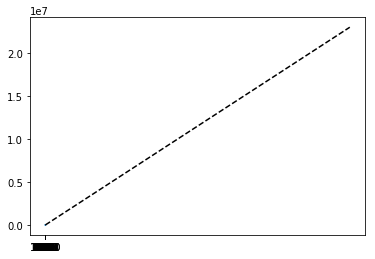

In [80]:
#Plot predictions vs actual
plt.plot(data[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')

print('R^2 : ', r2_score(data[target], prediction[target]))

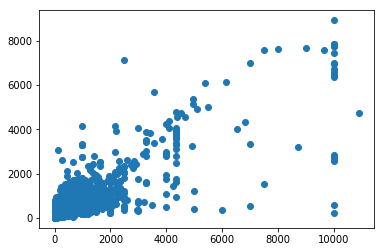

In [97]:
vis = pd.read_csv("data/vis.csv", header = 0)

plt.scatter(vis['actual'], vis['predicted'])

## Find out which machine learning model did Darwin use:

In [134]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBRegressor', 'parameters': {}}
